In [843]:
import yfinance as yf
import numpy as np
import ta
import pandas as pd
import matplotlib.pyplot as plt

In [844]:
df = yf.download('MATIC-USD', start='2022-1-15', interval = '1m')

[*********************100%***********************]  1 of 1 completed


In [845]:
df['%K'] = ta.momentum.stoch(df.High,df.Low,df.Close)

In [846]:
df['%D'] = df['%K'].rolling(3).mean()

In [847]:
df['RSI'] = ta.momentum.rsi(df.Close)

In [848]:
df['MACDiff'] = ta.trend.macd_diff(df.Close)

In [849]:
df.dropna(inplace= True)

In [850]:
df

,Open,High,Low,Close,Adj Close,Volume,%K,%D,RSI,MACDiff
Datetime,,,,,,,,,,
2022-01-14 13:33:00+00:00,2.230376,2.230376,2.230376,2.230376,2.230376,257024,39.126550,39.601873,56.448085,-0.000387
2022-01-14 13:34:00+00:00,2.229745,2.229745,2.229745,2.229745,2.229745,0,29.673707,38.019847,53.809036,-0.000501
2022-01-14 13:35:00+00:00,2.229962,2.229962,2.229962,2.229962,2.229962,0,32.929488,33.909915,54.596383,-0.000553
2022-01-14 13:36:00+00:00,2.229671,2.229671,2.229671,2.229671,2.229671,0,16.599207,26.400801,53.286441,-0.000595
2022-01-14 13:37:00+00:00,2.228933,2.228933,2.228933,2.228933,2.228933,0,0.000000,16.509565,50.004409,-0.000655
...,...,...,...,...,...,...,...,...,...,...
2022-01-21 06:13:00+00:00,1.916344,1.916344,1.916344,1.916344,1.916344,0,50.881887,33.982850,62.148390,-0.000142
2022-01-21 06:14:00+00:00,1.913945,1.913945,1.913945,1.913945,1.913945,174720,34.781794,39.615145,53.108396,-0.000166
2022-01-21 06:15:00+00:00,1.912851,1.912851,1.912851,1.912851,1.912851,539008,20.457491,35.373724,49.569781,-0.000251


In [851]:
def gettriggers(df, lags, buy=True):
    dfx = pd.DataFrame()
    for i in range(1,lags+1):
        if buy:
            mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
        else: 
            mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) > 80)
        dfx = dfx.append(mask,ignore_index=True)
    return dfx.sum(axis=0)

In [852]:
df['Buytrigger'] = np.where(gettriggers(df,8), 1, 0)

In [853]:
df['Selltrigger'] = np.where(gettriggers(df,8, False), 1, 0)

In [854]:
df['Buy'] = np.where((df.Buytrigger) & (df['%K'].between(20,80)) & (df['%D'].between(20,80))
                     & (df.MACDiff > 0) & (df.RSI > 50), 1, 0)
                    

In [855]:
df['Sell'] = np.where((df.Selltrigger) & (df['%K'].between(20,80)) & (df['%D'].between(20,80))
                     & (df.MACDiff <  0) & (df.RSI < 50), 1, 0)
                    

In [856]:
buy_dates, sell_dates = [],[]

In [857]:
for i in range(len(df)-1):
    if df.Buy.iloc[i]:
        buy_dates.append(df.iloc[i+1].name)
        for num,j in enumerate(df.Sell[i:]):
            if j:
                sell_dates.append(df.iloc[i + num + 1].name)
                break

In [858]:
cutit = len(buy_dates) - len(sell_dates)

In [859]:
if cutit:
    buy_dates = buy_dates[:-cutit]

In [860]:
frame = pd.DataFrame({'buy_dates':buy_dates, 'sell_dates':sell_dates})

In [861]:
actuals = frame[frame.buy_dates > frame.sell_dates.shift(1)]
actuals

,buy_dates,sell_dates
8,2022-01-15 05:15:00+00:00,2022-01-15 05:16:00+00:00
9,2022-01-15 08:39:00+00:00,2022-01-15 11:10:00+00:00
10,2022-01-15 12:05:00+00:00,2022-01-15 15:23:00+00:00
14,2022-01-15 18:56:00+00:00,2022-01-16 02:35:00+00:00
18,2022-01-16 04:38:00+00:00,2022-01-16 04:50:00+00:00
19,2022-01-16 09:29:00+00:00,2022-01-16 12:01:00+00:00
27,2022-01-16 15:31:00+00:00,2022-01-16 20:26:00+00:00
31,2022-01-16 23:18:00+00:00,2022-01-16 23:22:00+00:00
33,2022-01-17 07:27:00+00:00,2022-01-17 09:23:00+00:00
34,2022-01-17 13:39:00+00:00,2022-01-17 14:51:00+00:00


In [862]:
def profitcalc():
    Buyprices = df.loc[actuals.buy_dates].Open
    Sellprices = df.loc[actuals.sell_dates].Open
    
    
    
    
    return (Sellprices.values-Buyprices.values)/(Buyprices.values)

In [863]:
profitcalc()

array([-0.00085658,  0.00562277,  0.00051231, -0.01483437, -0.00044185,
       -0.00627975, -0.00644136, -0.00181973, -0.00169647, -0.00099392,
       -0.01150308, -0.01899836, -0.00070138, -0.00254487, -0.01864029,
       -0.0007123 ,  0.0018522 ,  0.01298645, -0.0800668 ])

In [870]:
profits = profitcalc()

# IF reversal short
#profits = profits*-1

In [871]:
profits.mean()*100

-0.7660916010305998

In [872]:
(profits+1).prod()

0.8610256665360232

In [873]:
winrate = len(profits[profits>0])/len(profits)*100
print('Wins: '+ str(len(profits[profits>0])))
print('Losses: '+ str(len(profits)-len(profits[profits>0])))
print(winrate)

Wins: 4
Losses: 15
21.052631578947366


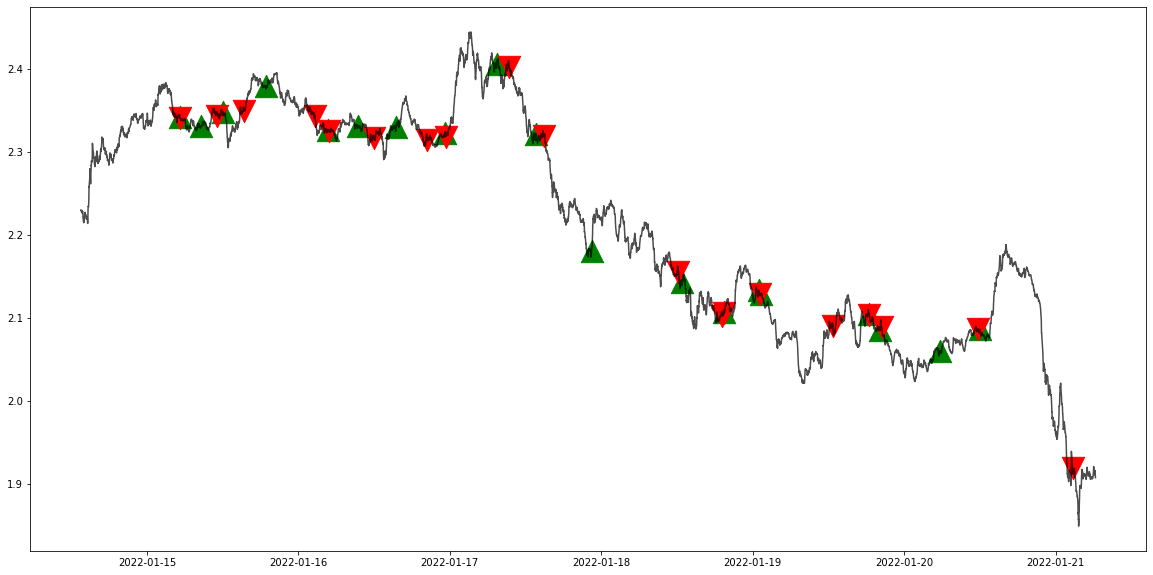

In [868]:
plt.figure(figsize=(20,10))
plt.plot(df.index,df.Close, color='k',alpha=0.7)
plt.scatter(actuals.buy_dates, df.Open[actuals.buy_dates],marker='^', color='g', s=500)
plt.scatter(actuals.sell_dates, df.Open[actuals.sell_dates],marker='v', color='r', s=500)


In [869]:
len(profits[profits>0])

15